# FRQI simulation

In [2]:
from dataLoader import MNISTDataLoader
from encoding import Encode,Probability
from circuitCreation import CreateCircuit
from functions import calc_difference,execute_sim,plot_to_compare

In [3]:
import matplotlib.pyplot as plt
from math import log2
from qiskit import Aer,execute
import numpy as np
from qiskit.tools.monitor import job_monitor

### Parameter initialitzation

In [4]:
# Set parameters
batch_size_train = 1
random_seed = 1

#parameters for the simulator
num_shots=8169 # Number of shots for the simulator or real backend
backend_state = Aer.get_backend('statevector_simulator')
backend_sim = Aer.get_backend('qasm_simulator')

### Import and visualize the image

In [5]:
#image details
num_pixels = [16,32]
pos_qubits = []
encoded_angles=[]
input_images = []
list_n = []
for pixels in num_pixels:
    N = int(log2(pixels))
    list_n.append(N)    
    m = 2**N
    pos_qubit = 2*N
    pos_qubits.append(2*N)
    num_qubits = pos_qubit+1

    data_loader = MNISTDataLoader(batch_size=batch_size_train, random_seed=random_seed, pixels=pixels)
    #data_loader = MNISTDataLoader(batch_size=batch_size_train, random_seed=random_seed)
    input_image, label = data_loader.get_batch()
    input_images.append(input_image)

    angleEncoding = Encode()
    encoded_angles.append(angleEncoding.angle_encoding(input_image, transformation='linear'))


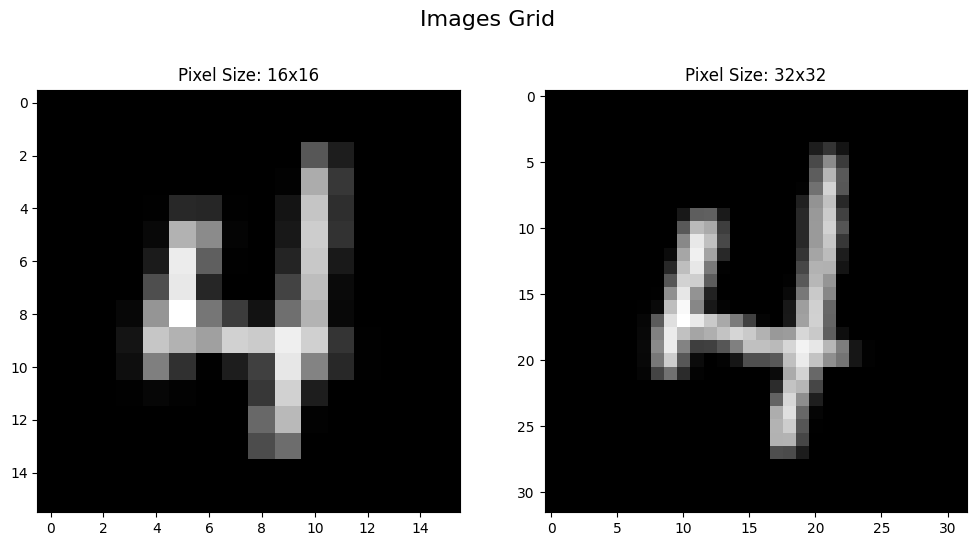

In [6]:
# Visualize the images in a grid
num_cols = len(num_pixels)
num_rows = 1  # One row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
fig.suptitle("Images Grid", fontsize=16)

for j, (pixels, images) in enumerate(zip(num_pixels, input_images)):
    axes[j].imshow(images.reshape(pixels, pixels), cmap='gray')
    axes[j].set_title(f"Pixel Size: {pixels}x{pixels}")

plt.show()

### Pre-processing: convert grey values into angles

### Creation of the quantum circuit

This is the circuit that we need to convert the classical image to a quantum state

In [ ]:
 '''def createFRQI_mary(self, method, circs, angles, measure_bool, num_qubits, pos_qubits, ancilla=None):
        start = time.time()

        img = QuantumRegister(pos_qubits, "img")
        color =  QuantumRegister(1,'gray_value')
        
        # Conditional creation of the ancilla register
        if ancilla == 1:
            anc = QuantumRegister(1, "anc")
            c = ClassicalRegister(img.size+color.size+anc.size,"classical_reg")
            circ = QuantumCircuit(color , anc, img, c)
        else:
            anc = None
            c = ClassicalRegister(img.size+color.size,"classical_reg")
            circ = QuantumCircuit(img,color,c)

        for i in range(1, len(img)):
            circ.h(img[i])

        i = 0
        for ang in angles:
            control_qubits = [j for j in range(pos_qubits)]
            if method == 'mary':
                if ang != 0:
                    # Determine the appropriate gate type based on the number of pixels
                    if num_qubits == 4:
                        gate_type = 'mary5'
                    elif num_qubits == 8:
                        gate_type = 'mary7'
                    elif num_qubits == 16:
                        gate_type = 'mary9'
                    elif num_qubits == 32:
                        gate_type = 'mary32'
                    elif num_qubits == 128:
                        gate_type = 'mary128'
                    elif num_qubits == 256:
                        gate_type = 'mary256'
                    else:
                        #print(f"Unsupported image size: {num_qubits}x{num_qubits}")
                        continue  # Skip the creation of MaryGate for unsupported image size


                    # Create MaryGate instance and apply the gate
                    if ancilla == 1:
                        mary_gate = MaryGate(circ=circ, angle=2 * ang, target=color, controls=img, bin=format(int(ang), '010b'),
                                         gate_type=gate_type, ancilla=ancilla)
                    
                    else:
                        mary_gate = MaryGate(circ=circ, angle=2 * ang, target=color, controls=img, bin=format(int(ang), '010b'),
                                         gate_type=gate_type)
                    mary_gate.apply_gate()

        if measure_bool:
            circ.measure_all()
            
        else:
            print('No measurements')
        end = time.time()
        print('Time needed: {:5.3f}s'.format(end - start), 'for creating circuit via', method)
        print("depth is {}, # of qubits is {}".format(circ.depth(), circ.num_qubits))
        circs.append(circ)'''

In [7]:
mary_circs=[]
measure_bool = True
circ_names_mary=[]
ancillas =[]
num_simulations = 1

mary_circuit = CreateCircuit()

for i in range(len(num_pixels)):
    print("----- Execution for an image of "+ str(num_pixels[i])+ " pixels -----")
    mary_circuit = CreateCircuit()
    mary_circuit.set_name('Circuit_mary_' + str(num_pixels[i]))
    if num_pixels[i] > 16:
        ancillas.append(1)
    else:
        ancillas.append(None)

    mary_circuit.createFRQI_mary('mary', mary_circs, encoded_angles[i], measure_bool, num_pixels[i], pos_qubits[i],ancilla=ancillas[i])
    circ_names_mary.append(mary_circuit.get_circuit_name())

----- Execution for an image of 16 pixels -----
Time needed: 0.008s for creating circuit via mary
depth is 1297, # of qubits is 9
----- Execution for an image of 32 pixels -----
Time needed: 0.054s for creating circuit via mary
depth is 3296, # of qubits is 12
----- Execution for an image of 64 pixels -----
Time needed: 0.002s for creating circuit via mary
depth is 2, # of qubits is 14
----- Execution for an image of 128 pixels -----
Time needed: 0.942s for creating circuit via mary
depth is 57746, # of qubits is 16


In [9]:
backend_names = []
results_mary=[]
counts_mary=[]
outputs_mary=[]
for a in range(num_simulations):
    result,counts_job = execute_sim(mary_circs, numOfShots=num_shots, backend=backend_sim, sim_bool=True)
    results_mary.append(result)
    counts_mary.append(counts_job)
    backend_names.append(backend_sim.name)

Used backend:  QasmSimulator('qasm_simulator')
Job_ID:  866c0662-9044-496b-8d23-8545ba979c81
Execution time:  41.17s


In [11]:
probability_instance = Probability()

for a in range(num_simulations):
        for i in range(len(circ_names_mary)):
                image_out = probability_instance.conversion_to_angle(counts = counts_mary[a][i], num_shots = num_shots, N=list_n[i], num_ancilla = ancillas[i], image = input_images[i])
               
                
                diff=calc_difference(image_out,input_images[i])
                print('Output_image with backend '+backend_names[0]+' and method '+circ_names_mary[i]+':', image_out, ' --> ', diff, '%')
                outputs_mary.append(image_out)

Output_image with backend qasm_simulator and method Circuit_mary_16: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  -->  8.09 %
Output_image with backend qasm_simulator and method Circuit_mary_32: [0 0 0 ... 0 0 0]  -->  8.06 %
Output_image with backend qasm_simulator and method Circuit_mary_64: [0 0 0 ... 0 0 0]  -->  8.19 %
Output_image with backend qasm_simulator and method Circuit_mary_128: [0 0 0 ... 0 0 0]  -->  8.19 %


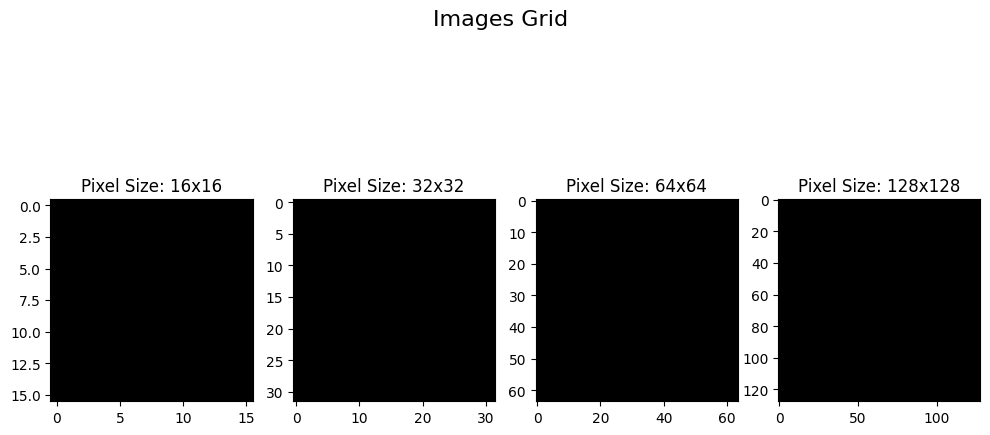

In [13]:
# Visualize the images in a grid
num_cols = len(num_pixels)
num_rows = 1  # One row

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))
fig.suptitle("Images Grid", fontsize=16)

for j, (pixels, images) in enumerate(zip(num_pixels, outputs_mary)):
    axes[j].imshow(images.reshape(pixels, pixels), cmap='gray')
    axes[j].set_title(f"Pixel Size: {pixels}x{pixels}")

plt.show()